<br>

# Elongate `snscrape`
## Collecting tweets to study the propagation of the news that covers Elon Musk's Twitter acquisition

<br>

This notebook details the web scraping of Twitter data for Group (lucky) #7's Final Project.

In [1]:
# python version must be >= 3.8 for snscrape to work properly
from platform import python_version
print(python_version())

3.10.4


In [ ]:
# to install snscrape
# this notebook uses the developer version
# pip3 install git+https://github.com/JustAnotherArchivist/snscrape.git

In [2]:
# Imports
import os
import pandas as pd
import snscrape
import pickle
import matplotlib.pyplot as plt

<br>

### scraping tweets with `snscrape`

*  To optimize daily tweet scraping, perform a seperate scrape for each day. scraping is a stochastic process, so this is one way to *try* to evenly collect data across the time frame of interest.
* use the following search parameters:
    * search query: "elon musk twitter"
    * since date (inclusive) YYYY-MM-DD
    * until date (exclusive) YYYY-MM-DD
* use the `os` python system library to run snscrape CLI command
    * general form: `snscrape [GLOBAL-OPTIONS] SCRAPER-NAME [SCRAPER-OPTIONS] [SCRAPER-ARGUMENTS...]`
    
<br>

In [3]:
# lists of strings used to build query string

# dates_str = ['01', '02', '03', '04', '05', 06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17',
#             '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30' ] 
dates_str = ['01', '02', '03', '04', '05', '06']
len( dates_str )

6

In [3]:
text_query = "elon musk twitter"
since_stem = "2022-04-"
until_stem = "2022-04-"

# loop over dates in the dates_str list
for idx in range( 0, len( dates_str )-1 ):
    since_date = since_stem+dates_str[idx]
    print(since_date)
    until_date = until_stem+dates_str[idx+1]
    os.system('snscrape --jsonl twitter-search "{} since:{} until:{}"> {}-tweets.json'.format(text_query, since_date, until_date, since_date))

<br>

Over the course of the scrape there were a few errors: 


* 2022-04-17 2022-05-15 02:12:12.391  WARNING  snscrape.modules.twitter  Unsupported unified_card type on tweet 1515565247876276227

* 2022-04-21 2022-05-15 02:43:51.553  WARNING  snscrape.modules.twitter  Unsupported unified_card type on tweet 1516939562270007297

* 2022-04-25 2022-05-15 03:06:28.919  CRITICAL  snscrape._cli  Dumped stack and locals to /tmp/snscrape_locals_mwzuw6kg Traceback (most recent call last):
    
* 2022-04-26 2022-05-15 04:20:46.795  WARNING  snscrape.modules.twitter  Unsupported unified_card type on tweet 1518737959071399936
    
* 2022-04-27 2022-05-15 05:44:22.676  WARNING  snscrape.modules.twitter  Unsupported unified_card type on tweet 1519304542420189184

* 2022-04-28 2022-05-15 06:23:37.606  CRITICAL  snscrape._cli  Dumped stack and locals to /tmp/snscrape_locals_lzwm9ajh
Traceback (most recent call last):


The unsupported call errors ( 4/17, 4/21, 4/26,  4/27 ) may have limitted the number of tweets  
However, the CRITICAL errors (4/25, 4/28) definitely led to a supstantially smaller tweet yield.  


As a result, a .json file is produced for each date scrape and saved to the directory the `snscrpae` CLI command was run. Next, the files need to be concatenated into a single pandas dataframe



In [4]:
# examining one of the scaper results

# Reads the json generated from the CLI command above and creates a pandas dataframe
tweets_df1 = pd.read_json('2022-04-01-tweets.json', lines=True)
# Displays first 5 entries from dataframe
tweets_df1.shape

(529, 29)

In [31]:
tweets_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   _type             529 non-null    object             
 1   url               529 non-null    object             
 2   date              529 non-null    datetime64[ns, UTC]
 3   content           529 non-null    object             
 4   renderedContent   529 non-null    object             
 5   id                529 non-null    int64              
 6   user              529 non-null    object             
 7   replyCount        529 non-null    int64              
 8   retweetCount      529 non-null    int64              
 9   likeCount         529 non-null    int64              
 10  quoteCount        529 non-null    int64              
 11  conversationId    529 non-null    int64              
 12  lang              529 non-null    object             
 13  sourc

In [97]:
tweets_df1['user'][0]

{'_type': 'snscrape.modules.twitter.User',
 'username': 'indiaExam12',
 'id': 1506615071891689475,
 'displayname': 'india Exam - indExam.in',
 'description': 'India Exam is a job Portal that provides details of all Sarkari exams, Sarkari Naukri, Govt Jobs, rojgar results,Admit Card, Admission, etc. indExam.in #indexam',
 'rawDescription': 'India Exam is a job Portal that provides details of all Sarkari exams, Sarkari Naukri, Govt Jobs, rojgar results,Admit Card, Admission, etc. https://t.co/TU6QSSmela #indexam',
 'descriptionUrls': [{'text': 'indExam.in',
   'url': 'http://indExam.in',
   'tcourl': 'https://t.co/TU6QSSmela',
   'indices': [141, 164]}],
 'verified': False,
 'created': '2022-03-23T12:53:32+00:00',
 'followersCount': 20,
 'friendsCount': 3,
 'statusesCount': 30353,
 'favouritesCount': 0,
 'listedCount': 0,
 'mediaCount': 1,
 'location': 'Fatehabad, Haryana',
 'protected': False,
 'linkUrl': 'https://indexam.in/',
 'linkTcourl': 'https://t.co/xxnp01s1Te',
 'profileImageUrl

<br>

The scrape results hold a row for each tweet with 29 fields of information. Some of the fields (e.g. 'user') are nested structures. We would like to produce a dataframe with all the tweet results that holds only the fields we would like to use for analysis. Furthermore, to make the dataframe more memory efficient, we would like to unnest the data fields we need from within nested structures.

<br>

In [5]:
# the fields we will pull from the original raw scrape result
snscols  = ['date', 'id', 'user', 'content', 'lang', 'replyCount', 'retweetCount', 
           'likeCount', 'inReplyToTweetId', 'inReplyToUser', 'mentionedUsers']
# the fields our preprocessed dataframe will hold
datacols = ['date', 'id', 'user_ID', 'user_name', 'user_location', 'content', 'lang', 'replyCount', 'retweetCount', 
           'likeCount', 'inReplyToTweetId', 'inReplyToUser_ID', 'inReplyToUser_name', 
           'mentionedUsers_ID', 'mentionedUsers_name']
# initialize an empty dataframe with columns = 'datacols'
df = pd.DataFrame(columns=datacols)
df

,date,id,user_ID,user_name,user_location,content,lang,replyCount,retweetCount,likeCount,inReplyToTweetId,inReplyToUser_ID,inReplyToUser_name,mentionedUsers_ID,mentionedUsers_name


In [6]:
# generate a list of all snscrape generated json files
path = '/home/bonzilla/Documents/MSDS/DATA620/Final_Project'
files = sorted( os.listdir(path) )
files = [file for file in files if 'tweets.json' in file]
files

['2022-04-01-tweets.json',
 '2022-04-02-tweets.json',
 '2022-04-03-tweets.json',
 '2022-04-04-tweets.json',
 '2022-04-05-tweets.json',
 '2022-04-06-tweets.json',
 '2022-04-07-tweets.json',
 '2022-04-08-tweets.json',
 '2022-04-09-tweets.json',
 '2022-04-10-tweets.json',
 '2022-04-11-tweets.json',
 '2022-04-12-tweets.json',
 '2022-04-13-tweets.json',
 '2022-04-14-tweets.json',
 '2022-04-15-tweets.json',
 '2022-04-16-tweets.json',
 '2022-04-17-tweets.json',
 '2022-04-18-tweets.json',
 '2022-04-19-tweets.json',
 '2022-04-20-tweets.json',
 '2022-04-21-tweets.json',
 '2022-04-22-tweets.json',
 '2022-04-23-tweets.json',
 '2022-04-24-tweets.json',
 '2022-04-25-tweets.json',
 '2022-04-26-tweets.json',
 '2022-04-27-tweets.json',
 '2022-04-28-tweets.json',
 '2022-04-29-tweets.json',
 '2022-04-30-tweets.json',
 '2022-05-01-tweets.json',
 '2022-05-02-tweets.json',
 '2022-05-03-tweets.json',
 '2022-05-04-tweets.json',
 '2022-05-05-tweets.json']

In [4]:
df = pd.DataFrame(columns=datacols)

num_tweets = 0

#for every file
for idx in range(0,len(files)):
    file = files[idx]
    # rad the file
    dfn = pd.read_json(file, lines=True)
    # subset just the cols we want
    dfn = dfn[snscols]
    # unnest user id, username, and location
    dfn['user_ID'] = [dfn['user'][idx]['id'] if dfn['user'][idx] else 0 for idx in range(0,dfn.shape[0] ) ]
    dfn['user_name'] = [dfn['user'][idx]['username'] if dfn['user'][idx] else 0 for idx in range(0,dfn.shape[0] ) ]
    dfn['user_location'] = [dfn['user'][idx]['location'] if dfn['user'][idx] else 0 for idx in range(0,dfn.shape[0] ) ]    
    # unnest the id & username from the inReplyToUser to see what user this tweet is retweeting
    dfn['inReplyToUser_ID'] = [dfn['inReplyToUser'][idx]['id'] if dfn['inReplyToUser'][idx] else 0 for idx in range(0,dfn.shape[0] ) ]
    dfn['inReplyToUser_name'] = [dfn['inReplyToUser'][idx]['username'] if dfn['inReplyToUser'][idx] else 0 for idx in range(0,len( dfn['inReplyToUser'] )) ]
    # unnest lists of just the ids and names of users that were mentioned (@ed) in this tweet
    mentioned_users_id = []
    mentioned_users_name = []
    for idx in range( 0, dfn.shape[0]):
        if dfn['mentionedUsers'][idx]:
            mu_id = [dfn['mentionedUsers'][idx][idxx]['id'] for idxx in range(0,len(dfn['mentionedUsers'][idx]))]
            mentioned_users_id.append( mu_id )
            mu_name = [dfn['mentionedUsers'][idx][idxx]['username'] for idxx in range(0,len(dfn['mentionedUsers'][idx]))]
            mentioned_users_name.append( mu_name ) 
        else:
            mentioned_users_id.append( 0 )
            mentioned_users_name.append( 0 )            
    num_tweets += dfn.shape[0]
    dfn['mentionedUsers_ID'] = mentioned_users_id
    dfn['mentionedUsers_name'] = mentioned_users_name  
    # drop nested fields from the df
    dfn = dfn.drop(columns=['user', 'inReplyToUser', 'mentionedUsers'])
    print( file + ': ' + str( dfn.shape[0] ) )
    # concatenat the results
    df = pd.concat([df,dfn], ignore_index=True)
print( ' ' )
print( num_tweets )

2022-04-01-tweets.json: 529
2022-04-02-tweets.json: 443
2022-04-03-tweets.json: 824
2022-04-04-tweets.json: 49143
2022-04-05-tweets.json: 71672
2022-04-06-tweets.json: 28854
2022-04-07-tweets.json: 15818
2022-04-08-tweets.json: 9432
2022-04-09-tweets.json: 12996
2022-04-10-tweets.json: 22185
2022-04-11-tweets.json: 33172
2022-04-12-tweets.json: 10921
2022-04-13-tweets.json: 10725
2022-04-14-tweets.json: 164264
2022-04-15-tweets.json: 107925
2022-04-16-tweets.json: 53995
2022-04-17-tweets.json: 21292
2022-04-18-tweets.json: 17858
2022-04-19-tweets.json: 16895
2022-04-20-tweets.json: 14118
2022-04-21-tweets.json: 17683
2022-04-22-tweets.json: 16459
2022-04-23-tweets.json: 14160
2022-04-24-tweets.json: 12178
2022-04-25-tweets.json: 7055
2022-04-26-tweets.json: 318251
2022-04-27-tweets.json: 154812
2022-04-28-tweets.json: 15816
2022-04-29-tweets.json: 69139
2022-04-30-tweets.json: 46226
2022-05-01-tweets.json: 30698
2022-05-02-tweets.json: 29786
2022-05-03-tweets.json: 24577
2022-05-04-twe

In [8]:
# save/load pickled df

# filehandler = open("elonmusktwitter_tweets_df.obj","wb")
# pickle.dump(df,filehandler)
# filehandler.close()

# file = open("elonmusktwitter_tweets_df.obj",'rb')
# df = pickle.load(file)
# file.close()

<br>

## EDA

Visualize the timeline of the data

In [9]:
# reformat 'date' from string the datetime type
df['date'] =  pd.to_datetime(df['date'])

In [10]:
# set the date as index for downstream aggregation
df.set_index('date', inplace=True)
df.head()

,id,user_ID,user_name,user_location,content,lang,replyCount,retweetCount,likeCount,inReplyToTweetId,inReplyToUser_ID,inReplyToUser_name,mentionedUsers_ID,mentionedUsers_name
date,,,,,,,,,,,,,,
2022-04-01 23:52:46+00:00,1510042521300307970,1506615071891689475,indiaExam12,"Fatehabad, Haryana",Twitter Brings Back Elon Musk’s Horror Show on...,en,0,0,0,NaN,0,0,0,0
2022-04-01 23:51:26+00:00,1510042183092649990,1497034745573781520,agent_x23,"Oneonta, New York",@Sublux8tor @iOfRome72 @Tweets4retweets @tesla...,en,0,0,1,1510040892148645888.0,1025107839080001537,Sublux8tor,"[1025107839080001537, 1494906005523775489, 145...","[Sublux8tor, iOfRome72, Tweets4retweets, tesla..."
2022-04-01 23:48:22+00:00,1510041411474837504,1493816517514993667,Tyrone4Tyrone,,"@thestanceman1 @elonmusk Sure, I chastised a b...",en,0,0,1,1507795059600764928.0,1123267215678160901,thestanceman1,"[1123267215678160901, 44196397]","[thestanceman1, elonmusk]"
2022-04-01 23:46:45+00:00,1510041004983963652,1466802565148983307,Brandon36054793,,@Twitter Work on a control+alt+delete :) @elon...,en,0,0,0,1509951255388504064.0,783214,Twitter,"[783214, 44196397]","[Twitter, elonmusk]"
2022-04-01 23:42:52+00:00,1510040029917110280,1356021036127404034,ThomasHBradford,The Metaverse,@SamTwits @robustus @elonmusk lol why do peopl...,en,0,0,0,1509344789115940864.0,1646555828,SamTwits,"[1646555828, 14144398, 44196397]","[SamTwits, robustus, elonmusk]"


In [11]:
# resample the data by hour and count occurances by hour
df_byday = df.resample('H').id.count()

In [12]:
df_byday_cs = df_byday.cumsum()
elon_hourly_df = pd.DataFrame( {'counts':df_byday, 'cumsum':df_byday_cs} )

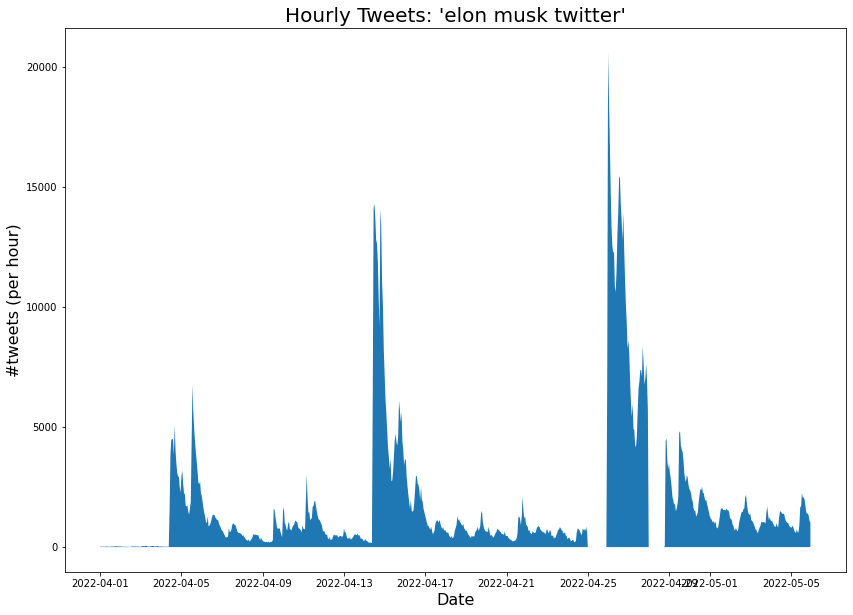

In [13]:
# hourly tweet rate
plt.figure(figsize=(14,10))
plt.fill_between(elon_hourly_df.index.tolist(), elon_hourly_df['counts'].tolist())
plt.title( "Hourly Tweets: 'elon musk twitter'", fontsize=20)
plt.ylabel( '#tweets (per hour)', fontsize = 16)
plt.xlabel( 'Date', fontsize = 16 )
plt.show()

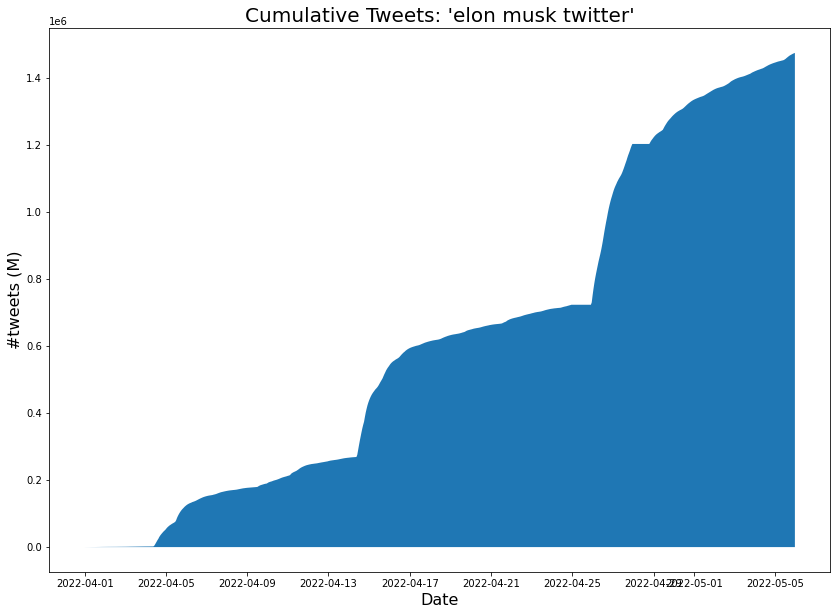

In [14]:
# cummulative tweets
plt.figure(figsize=(14,10))
plt.fill_between(elon_hourly_df.index.tolist(), elon_hourly_df['cumsum'].tolist())
plt.title( "Cumulative Tweets: 'elon musk twitter'", fontsize=20)
plt.ylabel( '#tweets (M)', fontsize = 16)
plt.xlabel( 'Date', fontsize = 16 )
plt.show()

In [7]:
# df.to_csv( 'elonmusktwitter_tweets.csv', index=False)